When navigating with a robot, obstacle detection and avoidance is an important task. There are many sensors and solutions to get information about obstacles in the environment. One solution is using a stereo camera setup. 

If we match a 3D point to the corresponding 2D pixel coordinate on each camera, we can measure the horizontal disparity distance d between these pixel coordinates. With a higher disparity, the normal distance z from the cameras to the 3D point will be smaller. We can accurately calculate this distance with known camera and stereo setup parameters. We can calculate a disparity map by calculating the disparity between each pixel in one camera, and the corresponding pixel in the other. Finally, a simple measure of obstacles is to calculate a single main disparity, giving a single obstacle distance measurement in front of the robot. Using this measurement, one could create a simple reactive robot which for example turns around when sufficiently close to an obstacle. 

In [1]:
import numpy as np
import cv2
import time
import pickle

import tkinter as tk
from PIL import Image, ImageTk

We start by calculating the disparity matrix. A huge computational advantage is to work with rectified images. We can then be sure that each horizontal row is colinear with the x-axis. Asuming no vertical shift between the two cameras, we can be sure that the corresponding point to match lies in the same horizontal pixel row on both cameras. If we only look for obstacles within a specific range, we can ... the search further. In addition, we will only calculate the disparity matrix in a square area in the center if the image, as we are interested in the obstacle directly in front of the robot.

Simply comparing a single intensity value against others does not work well, as there isn't enough information to differentiate the pixels. We will compare a block of intenseties around the reference pixel with block of intensities around the candidate pixels in the other image. 
We need a measure of simmilarity between the blocks. In this project Sum of Absolute Difference(SAD) is used, but there are other measures as well. With SAD, we simply sum the absolute difference between the block around the reference pixel in one image, with the block around the candidate pixel. We then get a scalar value of the cost of choosing this candidate pixel. We want to find the candidate pixel with the lowest cost.

Disparity has to be efficiently calculated, as this should run real time at a sufficient frame rate. With python, we definetly don't want to traverse over the image pixel by pixel, as even just accesing the data would be slow compared to more efficient solution. This problem can be efficiently solved with a box filter. When moving the block of the reference or candidate just one column or row, we simply need to add the new row or column, and remove the previous row or column. OpenCV filter2D has a efficient implementation that exploits this.

We first crop the reference left image. Then for each disparity d, we crop the right image after shifting it d pixels using a transfromation matrix. The absoulte difference matrix is calculated from the cropped images. We use filter2D on this matrix with the sum kernel of just 1's, obtaining the SAD. The result is stored in the 3D "volume" C=(x,y,d). After all disparities have been calculated, we find the disparity matrix as the argmin of the axis d at every (x,y)

In [2]:
def calculate_disparity_matrix(imgL, imgR,min_disp, max_disp, disp_size, window_radius):
    num_disp = max_disp-min_disp
    h, w = imgL.shape
    
    #The cropped center area we are interested in
    croph = [(h-disp_size)//2,(h+disp_size)//2]
    cropw = [(w-disp_size)//2,(w+disp_size)//2]

    ref_img_cropped = imgL[croph[0]:croph[1],cropw[0]:cropw[1]]

    #Simple sum kernel for our filter
    kernel = np.ones([window_radius, window_radius])

    #C(y,x,d) is the 3D volume containing the cost of a disparity at pixel x,y in the reference
    C = np.zeros(
        [disp_size, disp_size, max_disp])

    for d in range(min_disp, max_disp):
        # Shift image d pixels horizontally
        translation_matrix = np.float32([[1, 0, d], [0, 1, 0]])
        shifted_image = cv2.warpAffine(
            imgR, translation_matrix,
            (imgR.shape[1], imgR.shape[0]))
        shifted_image_cropped = shifted_image[croph[0]:croph[1],cropw[0]:cropw[1]]
        # Absolute difference
        AD = abs(np.float32(ref_img_cropped) - np.float32(shifted_image_cropped))
        # Calculate SAD.
        C[:, :, d] = cv2.filter2D(AD, -1, kernel)
    #Add min_disp as the index is shifted
    disparity = min_disp + np.argmin(C[:,:,min_disp:max_disp], axis=2)
    return disparity

Two simple functions to calculate the main disparity. Using the most frequent value seems to be the best of these two. We want to filter out outliers, as there are some completely wrong disparities genereted. Even with a ground truth disparity map, we need to decide the main disparity. The camera might see multiple obstacles at different distances. If we for example mostly see the checkerboard, but also some part of the background, the average method will get the distance somewhere in between. The most frequent method would get the distance to the checkerboard assuming it is the most frequent. 

Another porposal: Using the histogram, we arrange the disparities in bins, and choose the closest in distance bin with a sufficient amount of disparities.  

In [3]:
def main_disparity_mean(disparity):
    return np.mean(disparity)
def main_disparity_most_frequent(disparity):
    return np.bincount(disparity.flatten()).argmax()

To get a distance from the main disparity, we need some information about the cameras and their position. We assume the cameras to be equal with a focal length f, and the stereo rig to only have a horizontal displacement between the cameras, the baseline b. 

In [4]:
def get_distance_from_disparity(main_disp, f, b):
    distance = (f*b)/(main_disp*1000) #meter
    return distance

The main disparity should lie within a smaller range in each time instant than the range for the whole video. We can exploit this by dynamically changing the range, assuming that the main disparity does not change by a large amount frame to frame. This has a huge performance advantage, as we can reduce the number of disparities that needs to calculated and compared.

Non dynamic disparity calculation was tested on a laptop, running at around 7 fps with min_disp = 0, max_disp = 128, disparity_area_size = 100 and window_size = 8.
With dynamic disparity calculation, the fps was around 30 to 40, a huge increase. max_disp was set to 32, the rest of the settings the same. Distance calculation had no noticable difference between the runs. 

In [5]:
def calculate_disparity_matrix_dynamic_range(imgL, imgR,min_disp, max_disp, disp_size, window_radius, main_disp):
    num_disp = max_disp-min_disp
    h, w = imgL.shape
    
    #Use the previous main_disp to offset disparity search around the main disparity
    disp_offset = int(main_disp - max_disp//2)
    if(disp_offset>0):
        max_disp += disp_offset
        min_disp += disp_offset

    #The cropped center area we are interested in
    croph = [(h-disp_size)//2,(h+disp_size)//2]
    cropw = [(w-disp_size)//2,(w+disp_size)//2]

    ref_img_cropped = imgL[croph[0]:croph[1],cropw[0]:cropw[1]]

    #Simple sum kernel for our filter
    kernel = np.ones([window_radius, window_radius])

    #C(y,x,d) is the 3D volume containing the cost of a disparity at pixel x,y in the reference
    C = np.zeros(
        [disp_size, disp_size, max_disp])

    for d in range(min_disp, max_disp):
        # Shift image d pixels horizontally
        translation_matrix = np.float32([[1, 0, d], [0, 1, 0]])
        shifted_image = cv2.warpAffine(
            imgR, translation_matrix,
            (imgR.shape[1], imgR.shape[0]))
        shifted_image_cropped = shifted_image[croph[0]:croph[1],cropw[0]:cropw[1]]
        # Absolute difference
        AD = abs(np.float32(ref_img_cropped) - np.float32(shifted_image_cropped))
        # Calculate SAD.
        C[:, :, d] = cv2.filter2D(AD, -1, kernel)
    #Add min_disp as the index is shifted
    disparity = min_disp + np.argmin(C[:,:,min_disp:max_disp], axis=2)
    return disparity

To find the chessboard, we use the OpenCV function findChessboardCorners, which will return the corners of the internal squares. If we want, we can get some better accuracy by using a subpixel corner refinement algorith,, at the expense of computation time. 

To find the dimensions, we use the same formula as used to calculate depth from disparity.  

In [6]:
def find_chessboard(img, pattern_size):
    # Finding corners
    found, corners = cv2.findChessboardCorners(img, pattern_size)
    if found:
        # Refining corner position. Remove if performance is bad
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 5, 1)
        cv2.cornerSubPix(img, corners, (5, 5), (-1, -1), term)
        return True, corners
    else:
        return False, None
        
def calculate_chessboard_dimensions(distance, corners, pattern_size, f):
    #Calculate pixel difference between top left and top right corner, and top left and bottom left corner respectively
    #w_pixel = abs(corners[0,0,0]-corners[pattern_size[0]-1,0,0])
    #h_pixel = abs(corners[0,0,1]-corners[(pattern_size[0]-1)*pattern_size[1]-1,0,1])

    #Calculating x,y pixel distance wrt the two diagonal corners
    w_pixel = abs(corners[0,0,0]-corners[pattern_size[0]*pattern_size[1]-1,0,0])
    h_pixel = abs(corners[0,0,1]-corners[pattern_size[0]*pattern_size[1]-1,0,1]) 
    #Calculate dimensions in mm 
    w = (distance*w_pixel)/f #mm
    h = (distance*h_pixel)/f #mm
    return w,h

The parameters that are not given are set by experimentation. The visual representation of the disparity map was used for tuning. For example the window size was determined looking at the disparity map with minimal cropping.

In [7]:
#Parameters

#Stereo cameras
focal_length = 567.2 #pixels
baseline = 92.226 #mm

#Stereo matching algorithm
min_disp=0
max_disp=32

num_disp = max_disp-min_disp
disparity_area_size = 80
window_radius = 8

#Chessboard
pattern_size = (6,8)

We create a GUI with tkinter. Here we display the rgb camera feed from the left camera, the disparity map transformed to a color heat map, the distance to an obstacle, as well as the fps. Optionally the chessboard dimensions will be calculated and displayed. The video will run as fast as calculations are done. If we had a real time camera feed, this could be pretty easily altered to do the next calculation on the newest frame.  

In [8]:
class MainWindow():
    def __init__(self, window):
        self.use_dynamic_disparity_range = True
        self.calculate_checkerboard = True
        self.main_disp = max_disp//2

        self.window = window
        self.vidL = cv2.VideoCapture('../data/robotL.avi')
        self.vidR = cv2.VideoCapture('../data/robotR.avi')
        if (self.vidL.isOpened()==False or self.vidR.isOpened()==False):
            print("Error opening video")

        self.width = 1200
        self.height = 600
        self.interval = 1 # Interval in ms to get the latest frame
        
        #Logging
        self.distances = []
        self.chess_h = []
        self.chess_w = []

        self.distance_widget = tk.Label(root, text="Distance: 0", width=100)
        self.distance_widget.config(font=("Courier", 20))
        self.dimension_widget = tk.Label(root, text="Chessboard dimensions: ", width=100)
        self.dimension_widget.config(font=("Courier", 20))
        self.fps_widget = tk.Label(root, text="FPS: 0", width=100)
        self.fps_widget.config(font=("Courier", 20))

        # Create canvas for gui
        self.canvas = tk.Canvas(self.window, width=self.width, height=self.height)
        self.canvas.grid(row=0, column=0)
        # Update gui
        self.update_gui()
    def update_gui(self):

        # Capture frame-by-frame
        retL, frameL = self.vidL.read()
        retR, frameR = self.vidR.read()
        if retL == True and retR == True:
            frameL_greyscale=cv2.cvtColor(frameL, cv2.COLOR_BGR2GRAY)
            frameR_greyscale=cv2.cvtColor(frameR, cv2.COLOR_BGR2GRAY)
            
        
            start = time.time()
            
            if(self.use_dynamic_disparity_range):
                disparity = calculate_disparity_matrix_dynamic_range(frameL_greyscale, frameR_greyscale,min_disp, max_disp, 
                disparity_area_size, window_radius, self.main_disp)
            else:
                disparity = calculate_disparity_matrix(frameL_greyscale, frameR_greyscale,min_disp, max_disp, 
                disparity_area_size, window_radius)
            
            self.main_disp = main_disparity_most_frequent(disparity)
            
            distance = get_distance_from_disparity(self.main_disp, focal_length, baseline)
            self.distances.append(distance)
            
            #Find chessboard corners
            if self.calculate_checkerboard:
                ret, corners = find_chessboard(frameL_greyscale, pattern_size)
                if ret:
                    #frameL = cv2.resize(frameL, (frameL.shape[1]//8, frameL.shape[0]//8))
                    cv2.drawChessboardCorners(frameL, pattern_size, corners, True)
                    w,h = calculate_chessboard_dimensions(distance*1000, corners, pattern_size, focal_length)
                    error_w, error_h = abs(125 - w), abs(178-h)
                    self.chess_w.append(w)
                    self.chess_h.append(h)
                    self.dimension_widget["text"] = ("Chessboard dimensions: "+str(round(w)) + "mm x " 
                        + str(round(h)) + "mm. Error: " + str(round(error_w)) + "mm , " + str(round(error_h)) + "mm")
                    self.dimension_widget.config(fg="green")
                else:
                    self.chess_w.append(np.nan)
                    self.chess_h.append(np.nan)
                    self.dimension_widget.config(fg="red")
            
            #We calculate fps without GUI, as that is not as interesting
            fps = 1/(time.time()-start)
            # Scale disparity values for visualization 
            disparity_visual = np.uint8(disparity * 128 / num_disp)
            disp_heatmap = cv2.applyColorMap(disparity_visual, cv2.COLORMAP_JET)
    
            blue,green,red = cv2.split(frameL)
            self.image_rgb = cv2.merge((red,green,blue))
            self.image_rgb = Image.fromarray(self.image_rgb)
            self.image_rgb = ImageTk.PhotoImage(image=self.image_rgb, master=root)

            # Update image
            self.canvas.create_image(0, 0, anchor=tk.NW, image=self.image_rgb)

            blue,green,red = cv2.split(disp_heatmap)
            self.image_disp = cv2.merge((red,green,blue))
            self.image_disp = Image.fromarray(self.image_disp)
            self.image_disp = ImageTk.PhotoImage(image=self.image_disp, master=root)
            
            self.canvas.create_image(680, 250, anchor=tk.NW, image=self.image_disp)
            if(distance<0.8):
                self.distance_widget["text"] = "ALARM! Distance to obstacle: "+str(round(distance,2)) + "m"
                self.distance_widget.config(fg="red")
            else:
                self.distance_widget["text"] = "Distance to obstacle: "+str(round(distance,2)) + "m"
                self.distance_widget.config(fg="black")

            self.fps_widget["text"] = "FPS: " + str(round(fps))

            self.distance_widget.grid()
            self.dimension_widget.grid()
            self.fps_widget.grid()

            self.window.after(self.interval, self.update_gui)
            

        # Break the loop
        else:             
            # When everything done, release the video capture object
            self.vidL.release()
            self.vidR.release()
            # Closes all the frames
            cv2.destroyAllWindows()
            with open("../data/log1", 'wb') as out:
                pickle.dump([self.distances, self.chess_h, self.chess_w], out, pickle.HIGHEST_PROTOCOL)
            
            quit()
if __name__ == "__main__":
    root = tk.Tk()
    MainWindow(root)
    root.mainloop()

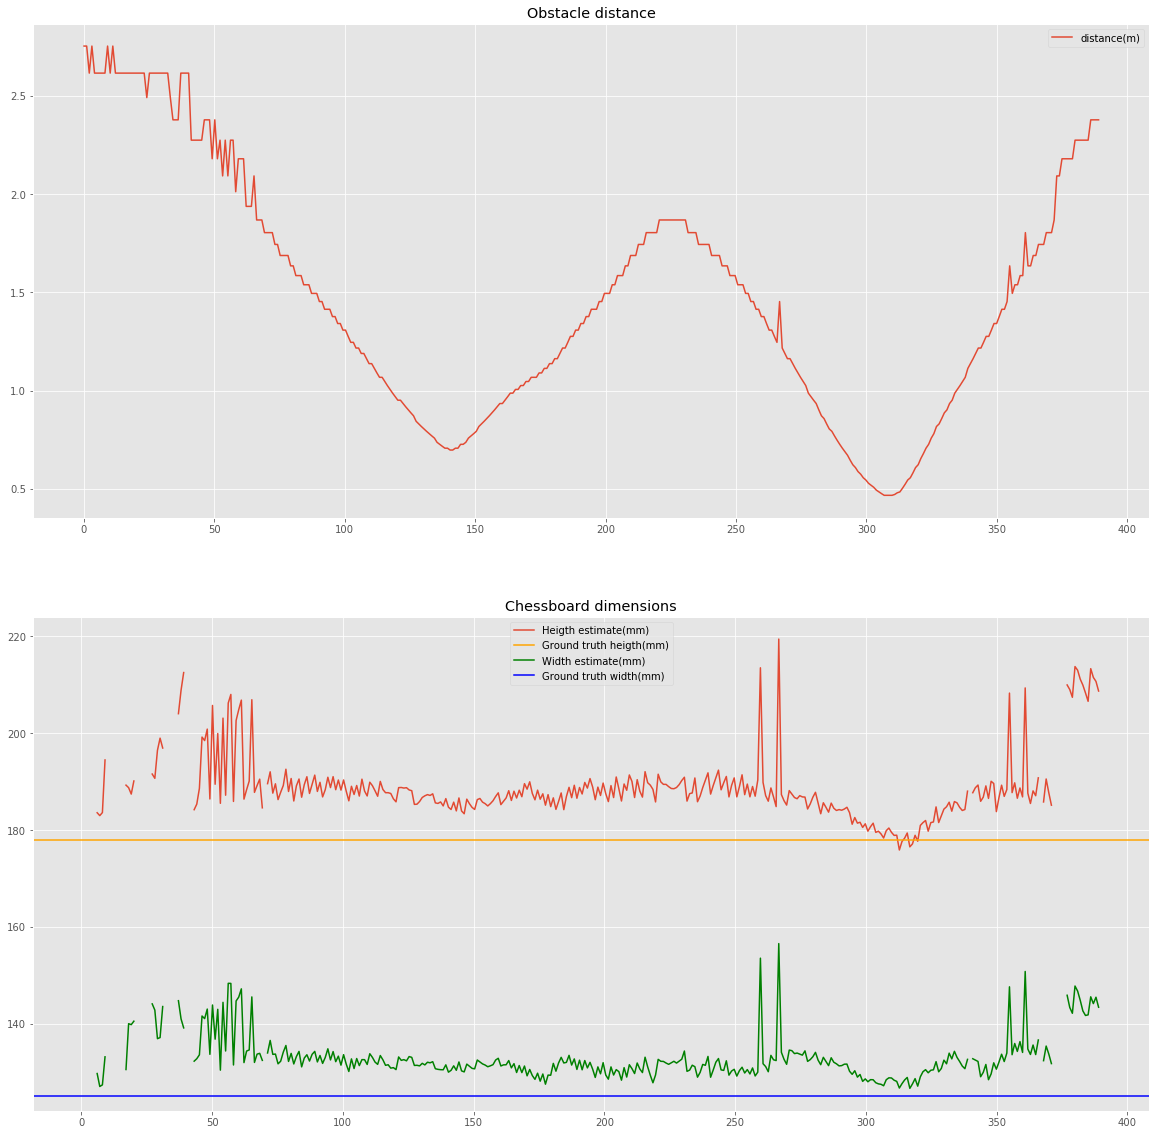

In [2]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

with open("../data/log1", 'rb') as p_in:
    distance, chess_h, chess_w = pickle.load(p_in)

x = np.linspace(0, len(distance), len(distance))


fig, ax = plt.subplots(2)

fig.set_size_inches(20,20)

ax[0].plot(x,distance, label="distance(m)")
ax[0].set_title("Obstacle distance")
ax[0].set_ylabel="meter"
ax[0].legend()

ax[1].plot(x,chess_h, label="Heigth estimate(mm)")
ax[1].axhline(178, label="Ground truth heigth(mm)", color="orange")
ax[1].set_title("Chessboard dimensions")
ax[1].set_ylabel="mm"


ax[1].plot(x,chess_w, label= "Width estimate(mm)", color="green")
ax[1].axhline(125, label="Ground truth width(mm)", color="blue")
ax[1].legend()
#ax[2].set_title("Chessboard width")
#ax[2].set_ylabel="mm"
#ax[2].set_xlabel("time")
#ax[2].legend()

plt.show()